### Classification Model Using XGBoost

The input of the Model will be the following:

- From policy A to policy G (excluding Policy F - decided to drop it due to high uncertainty and limitations with NLP packages)

In [2]:
%pip install xgboost scikit-learn pandas matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Imports ---
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# for reproducibility
np.random.seed(42)

In [4]:
FEATURES_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/feature_engineering_model/temp.csv"
LABELS_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/data_gpt_labeler/final_data_labeled_1.csv"
TEXT_COL = "text"
TARGET_COL = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]


In [5]:
# Load
df_feat  = pd.read_csv(FEATURES_CSV)
df_label = pd.read_csv(LABELS_CSV)

print("Features shape:", df_feat.shape)
print("Labels shape:", df_label.shape)

Features shape: (10000, 5)
Labels shape: (10000, 8)


In [6]:
# Align by index since order is guaranteed
df = pd.concat([df_feat.reset_index(drop=True), 
                df_label[[TARGET_COL, TEXT_COL]].reset_index(drop=True)], axis=1)

print("Merged dataset shape:", df.shape)
df.head()


Merged dataset shape: (10000, 7)


,A,B,D2,E,G,policy_label,text
0,0.126823,0.581653,0.660104,0.993421,0.999407,1,My husband took me here for my birthday! The ...
1,0.066522,0.565305,0.620909,0.360918,0.997275,1,was a great place. Now closed. Too bad. We'll...
2,0.158263,0.575038,0.551840,0.987322,0.999049,1,"cozy, great food. love how you can sign your b..."
3,0.062633,0.575837,0.630236,0.859828,0.999422,1,"Not your average little Italian joint, don't e..."
4,0.005904,0.572793,0.792418,0.901759,0.999557,1,Service was great and the mozzarella fritta an...


In [7]:
if TEXT_COL in df.columns:
    # Define regex patterns
    link_pattern = r"(https?://\S+|www\.\S+)"       # http://, https://, www.
    email_pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"  # emails
    phone_pattern = r"\b(?:\+?\d{1,3})?[-.\s]?\(?\d{2,4}\)?[-.\s]?\d{3,4}[-.\s]?\d{3,4}\b"  # phone numbers
    combined_re = re.compile(f"({link_pattern})|({email_pattern})|({phone_pattern})", flags=re.IGNORECASE)

    mask_dirty = df[TEXT_COL].astype(str).str.contains(combined_re, na=False)
    # Rows flagged as spam/advertising
    df_dropped = df.loc[mask_dirty].copy()

    print("Dropped rows shape:", df_dropped.shape)
    df_dropped[[TEXT_COL, TARGET_COL]].head(10)   # peek at text + label

    print(f"Total rows: {len(df)}")
    print(f"Rows flagged as spam/advertising: {mask_dirty.sum()}")

    df = df.loc[~mask_dirty].reset_index(drop=True)
    print("Rows after cleaning:", len(df))


Dropped rows shape: (0, 7)
Total rows: 10000
Rows flagged as spam/advertising: 0
Rows after cleaning: 10000


/var/folders/0m/d4xwfvr11f9g7yflwxh0w_c40000gn/T/ipykernel_69467/3022558074.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_dirty = df[TEXT_COL].astype(str).str.contains(combined_re, na=False)


In [8]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance:", dict(zip(*np.unique(y, return_counts=True))))


X shape: (10000, 5)
y shape: (10000,)
Class balance: {np.int64(0): np.int64(1090), np.int64(1): np.int64(8910)}


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if len(np.unique(y)) == 2 else None
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 5)
Test shape: (2000, 5)


In [13]:
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

# inspect class balance on the TRAIN SET (not whole data)
ctr_train = Counter(y_train)
neg = ctr_train.get(0, 0)
pos = ctr_train.get(1, 0)
print("Train class balance:", dict(ctr_train))

# Compute scale_pos_weight = (#negatives / #positives)
# If class 1 is the MAJORITY, this ratio will be < 1.0, which is fine.
# XGBoost will still re-weight the positive class appropriately.
if pos == 0:
    raise ValueError("No positive samples in y_train; cannot compute scale_pos_weight.")
scale_pos_weight = neg / pos
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.6f}")

# OR Use class_weight in fit()
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Train XGBoost with class weighting
xgb_clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    # scale_pos_weight = scale_pos_weight
)
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)


Train class balance: {np.int64(0): 872, np.int64(1): 7128}
scale_pos_weight (neg/pos): 0.122334


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = xgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.844

Classification Report:
              precision    recall  f1-score   support

           0     0.3549    0.5275    0.4244       218
           1     0.9385    0.8827    0.9098      1782

    accuracy                         0.8440      2000
   macro avg     0.6467    0.7051    0.6671      2000
weighted avg     0.8749    0.8440    0.8569      2000



array([[ 115,  103],
       [ 209, 1573]])

### Using scale_pos_weight

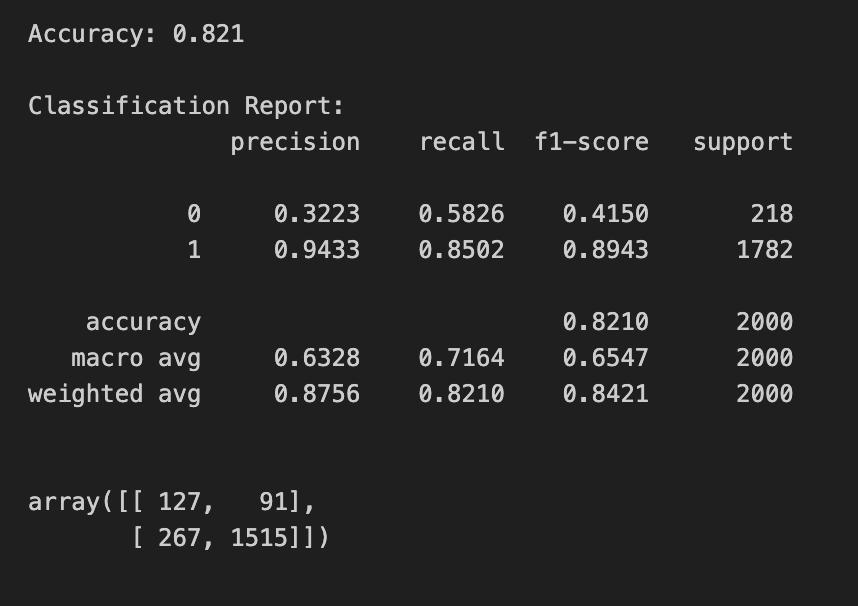

### Using class_weight in fit()

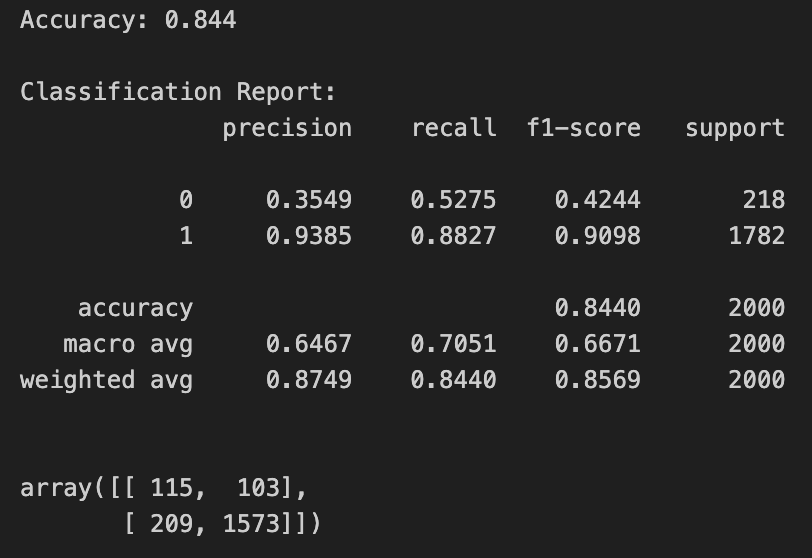

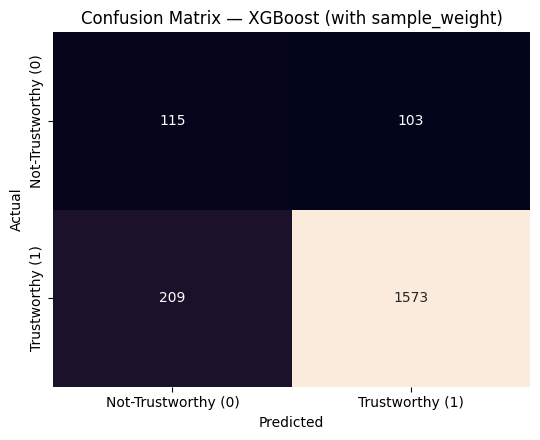

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    cm, annot=True, fmt="d", cbar=False,
    xticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"],
    yticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"]
)
plt.title("Confusion Matrix — XGBoost (with sample_weight)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Using scale_pos_weight

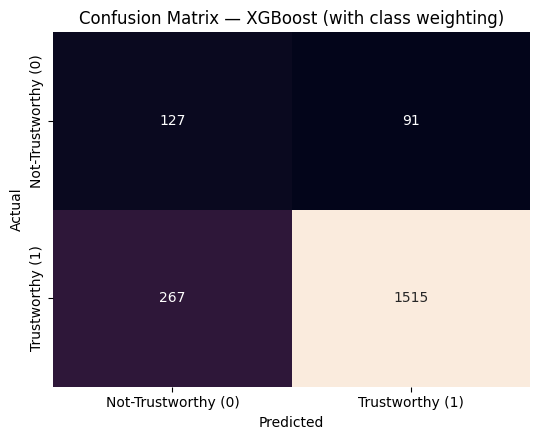


# XGBoost - Fine-tuned Pipeline

__(monotonic + class weight + CV threshold tuning)__

In [8]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
FINAL_CSV = "../final_data_featured_filtered.csv"
TARGET_COL = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]


In [19]:
df  = pd.read_csv(FINAL_CSV)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:20])
missing = [c for c in FEATURE_COLS + [TARGET_COL] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")


Loaded shape: (31120, 6)
Columns: ['A', 'B', 'D2', 'E', 'G', 'policy_label']


In [21]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].astype(int).values

In [22]:
# Cross Validation and Training

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mono = "(1,1,1,1,1)"  # monotonic constraints: higher score => more trustworthy

metrics = []

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X[tr], X[va]
    y_tr, y_va = y[tr], y[va]

    neg, pos = np.bincount(y_tr)
    spw = neg / pos

    clf = XGBClassifier(
        learning_rate=0.05, 
        n_estimators=2000, 
        max_depth=3,
        min_child_weight=15, 
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=2.0, 
        random_state=42, 
        n_jobs=-1,
        tree_method="hist", 
        eval_metric="aucpr",
        scale_pos_weight=spw,
        monotone_constraints=mono,
        early_stopping_rounds=100,
    )
    clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    # threshold tuning for minority class (class 0)
    p = clf.predict_proba(X_va)[:,1]
    prec, rec, thr = precision_recall_curve(y_va, p)

    # Flip labels: focus on class 0 (not-trustworthy)
    beta = 2
    f2_scores = []
    for t in thr:
        y_hat = (p >= t).astype(int)
        tp = np.sum((y_hat==0) & (y_va==0))
        fp = np.sum((y_hat==0) & (y_va==1))
        fn = np.sum((y_hat==1) & (y_va==0))
        prec0 = tp / (tp+fp+1e-12)
        rec0  = tp / (tp+fn+1e-12)
        f2 = (1+beta**2)*(prec0*rec0)/(beta**2*prec0+rec0+1e-12)
        f2_scores.append((prec0,rec0,f2,t))
    best = max(f2_scores, key=lambda x: x[2])
    prec0, rec0, f2, t_best = best

    # Final predictions
    y_hat = (p >= t_best).astype(int)
    cm = confusion_matrix(y_va, y_hat)

    metrics.append({
        "fold": fold,
        "threshold": t_best,
        "prec0": prec0, 
        "rec0": rec0, 
        "f2_0": f2,
        "f1_macro": f1_score(y_va, y_hat, average="macro"),
        "cm": cm
    })
    
# ---------------- Results ----------------
for m in metrics:
    print(f"Fold {m['fold']} | Th={m['threshold']:.3f} | Prec0={m['prec0']:.3f} | Rec0={m['rec0']:.3f} | F2_0={m['f2_0']:.3f} | F1_macro={m['f1_macro']:.3f}")
    print(m["cm"], "\n")

print("Average Prec0:", np.mean([m["prec0"] for m in metrics]))
print("Average Rec0:", np.mean([m["rec0"] for m in metrics]))

Fold 1 | Th=0.485 | Prec0=0.289 | Rec0=0.735 | F2_0=0.562 | F1_macro=0.628
[[ 556  200]
 [1365 4103]] 

Fold 2 | Th=0.552 | Prec0=0.258 | Rec0=0.771 | F2_0=0.551 | F1_macro=0.595
[[ 583  173]
 [1681 3787]] 

Fold 3 | Th=0.560 | Prec0=0.266 | Rec0=0.791 | F2_0=0.567 | F1_macro=0.603
[[ 599  158]
 [1656 3811]] 

Fold 4 | Th=0.540 | Prec0=0.269 | Rec0=0.795 | F2_0=0.572 | F1_macro=0.606
[[ 602  155]
 [1635 3832]] 

Fold 5 | Th=0.518 | Prec0=0.273 | Rec0=0.768 | F2_0=0.563 | F1_macro=0.611
[[ 581  176]
 [1551 3916]] 

Average Prec0: 0.27083956743858256
Average Rec0: 0.7721285637401876


## Updated XGBoost Pipeline with SMOTE + Tomek

In [23]:

from imblearn.combine import SMOTETomek 

In [24]:
FINAL_CSV   = "../final_data_featured_filtered.csv"
TARGET_COL  = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]

In [25]:
df = pd.read_csv(FINAL_CSV)
print("Loaded shape:", df.shape)

Loaded shape: (31120, 6)


In [26]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].astype(int).values
print("Class balance:", dict(zip(*np.unique(y, return_counts=True))))

Class balance: {np.int64(0): np.int64(3783), np.int64(1): np.int64(27337)}


In [27]:
def evaluate_with_smote_tomek(model, X, y, model_name="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    smt = SMOTETomek(random_state=42)   # 👈 combo resampler

    metrics = []

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_va, y_va = X[va], y[va]

        # Resample training set only
        X_res, y_res = smt.fit_resample(X_tr, y_tr)

        # Fit
        model.fit(X_res, y_res)

        # Probs + threshold tuning for class 0
        p = model.predict_proba(X_va)[:, 1]
        prec, rec, thr = precision_recall_curve(y_va, p)

        beta = 2
        best = None
        for t in thr:
            y_hat = (p >= t).astype(int)
            tp0 = np.sum((y_hat == 0) & (y_va == 0))
            fp0 = np.sum((y_hat == 0) & (y_va == 1))
            fn0 = np.sum((y_hat == 1) & (y_va == 0))
            prec0 = tp0 / (tp0 + fp0 + 1e-12)
            rec0  = tp0 / (tp0 + fn0 + 1e-12)
            f2_0  = (1 + beta**2) * (prec0 * rec0) / (beta**2 * prec0 + rec0 + 1e-12)
            if (best is None) or (f2_0 > best[0]):
                best = (f2_0, prec0, rec0, t)

        f2_0, prec0, rec0, t_best = best
        y_hat = (p >= t_best).astype(int)
        cm = confusion_matrix(y_va, y_hat)

        metrics.append({
            "fold": fold,
            "threshold": float(t_best),
            "prec0": float(prec0),
            "rec0": float(rec0),
            "f2_0": float(f2_0),
            "f1_macro": float(f1_score(y_va, y_hat, average="macro")),
            "cm": cm
        })

    print(f"=== {model_name} with SMOTE+Tomek ===")
    for m in metrics:
        print(f"Fold {m['fold']} | Th={m['threshold']:.3f} | "
              f"Prec0={m['prec0']:.3f} | Rec0={m['rec0']:.3f} | "
              f"F2_0={m['f2_0']:.3f} | F1_macro={m['f1_macro']:.3f}")
        print(m["cm"], "\n")

    print(f"[{model_name}] Avg Prec0:", np.mean([m["prec0"] for m in metrics]))
    print(f"[{model_name}] Avg Rec0 :", np.mean([m["rec0"] for m in metrics]))
    return metrics


In [28]:
mono = (1,1,1,1,1)

xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,   # fewer trees, resampled data
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="aucpr",
    monotone_constraints=mono
)

xgb_metrics = evaluate_with_smote_tomek(xgb_model, X, y, "XGBoost")


=== XGBoost with SMOTE+Tomek ===
Fold 1 | Th=0.581 | Prec0=0.253 | Rec0=0.792 | F2_0=0.555 | F1_macro=0.588
[[ 599  157]
 [1773 3695]] 

Fold 2 | Th=0.553 | Prec0=0.259 | Rec0=0.747 | F2_0=0.543 | F1_macro=0.597
[[ 565  191]
 [1616 3852]] 

Fold 3 | Th=0.577 | Prec0=0.254 | Rec0=0.793 | F2_0=0.557 | F1_macro=0.590
[[ 600  157]
 [1759 3708]] 

Fold 4 | Th=0.541 | Prec0=0.272 | Rec0=0.801 | F2_0=0.576 | F1_macro=0.609
[[ 606  151]
 [1623 3844]] 

Fold 5 | Th=0.527 | Prec0=0.270 | Rec0=0.765 | F2_0=0.559 | F1_macro=0.608
[[ 579  178]
 [1569 3898]] 

[XGBoost] Avg Prec0: 0.26147078365394144
[XGBoost] Avg Rec0 : 0.7795349227317513


__Next steps to really lift precision0 would be:__

- Richer features: Add review text embeddings, sentiment, rating, etc.

- Probability calibration: Use CalibratedClassifierCV to stabilize predicted probabilities before thresholding.

- Hybrid ensemble: Combine RF + XGB (stacking or voting). Sometimes the errors aren’t correlated.

- Anomaly detection framing: Train a one-class model on “trustworthy” reviews, flag deviations as “not-trustworthy.”